In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def scores(classifier, X, y):
    precision = cross_val_score(classifier, X, y, cv=10, scoring='precision').mean()
    recall = cross_val_score(classifier, X, y, cv=10, scoring='recall').mean()
    f1 = cross_val_score(classifier, X, y, cv=10, scoring='f1').mean()
    columns = ['precision', 'recall', 'f1']
    results = pd.DataFrame([precision, recall, f1], index=columns).T
    return results

In [0]:
df = pd.read_csv('sin_movie.csv')

1000 положительных и 1000 отрицательных отзывов
* столбец text - просто текст отзыва
* столбец sin_text - синтаксические биграммы, построенные по дереву зависимостей

In [4]:
df

,text,labels,sin_text
0,now that boogie nights has made disco respecta...,1.0,surprisedmade madenow madethat madenights nigh...
1,based on the relatively unknown in comparison ...,1.0,tellscomparison comparisonbased comparisonon c...
2,i was going to see ram shrasta on the big scre...,0.0,goingi goingwas goingsee seeto seeshrasta shra...
3,i wonder if budget is at all a criterion for w...,0.0,wonderi wondercriterion criterionif criterionb...
4,modern audiences are more likely to be familia...,1.0,likelyaudiences audiencesmodern likelyare like...
...,...,...,...
1995,call me crazy but i don t see saving private r...,1.0,callme callcrazy callsee seebut seei it tdon s...
1996,s alien marked not only the death by suicide o...,1.0,includedmarked markeds markedalien markedsavag...
1997,plot two sister witches have to live with a cu...,0.0,plotwitches witchestwo witchessister plothave ...
1998,deserves recognition for achieving the near im...,0.0,deservesrecognition deservesachieving achievin...


Столбец all - комбинация униграмм и синтаксических биграмм

In [0]:
df['all'] = df['text'] + df['sin_text']

* X - униграммы
* XS - синнтаксические биграммы
* X_all - все вместе

In [0]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df['text'])
XS = vectorizer.fit_transform(df['sin_text'])
X_all = vectorizer.fit_transform(df['all'])

y = df['labels']

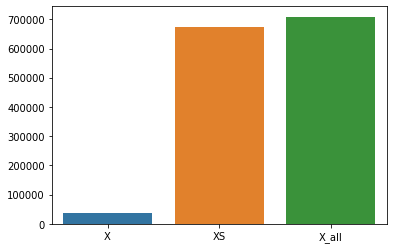

In [8]:
sns.barplot(['X', 'XS', 'X_all'], 
            [X.shape[1], XS.shape[1], X_all.shape[1]])

In [0]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Почти везде нули, но где-то внутри есть другие числа

SVD

* sX - униграммы
* sXS - синнтаксические биграммы
* sX_all - все вместе

In [0]:
svd = TruncatedSVD(n_components=200, n_iter=20, random_state=42)
sX = svd.fit_transform(X)
sXS = svd.fit_transform(XS)
sX_all = svd.fit_transform(X_all)

### MultinomialNB

In [0]:
mnb = M`ultinomialNB()

До SVD

In [11]:
for i in [X, XS, X_all]:
  print(scores(mnb, i, y))

   precision  recall        f1
0   0.854463   0.746  0.795236
   precision  recall        f1
0   0.848442    0.83  0.838361
   precision  recall        f1
0   0.820806    0.87  0.843945


После SVD

In [14]:
for i in [sX, sXS, sX_all]:
  i = i + abs(i.min(axis=0))
  print(scores(mnb, i, y))

   precision  recall        f1
0   0.812505   0.805  0.807881
   precision  recall        f1
0   0.812708   0.811  0.810907
   precision  recall        f1
0   0.825739   0.807  0.815386


### RandomForest

In [0]:
rfc = RandomForestClassifier(random_state=42)

In [0]:
random_grid = {'n_estimators': [i for i in range(100, 601, 100)],
               'max_features': 2**np.arange(1, 15),
               'max_depth': [i for i in range(10, 111, 10)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}

До SVD

In [13]:
for ite in [X, XS, X_all]:
  rf_random = RandomizedSearchCV(rfc, random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs=-1)
  rf_random.fit(ite, y)
  print(scores(rf_random.best_estimator_, ite, y))
  print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 45.9min finished


   precision  recall        f1
0   0.841304   0.811  0.825293
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 512, 'max_depth': 20}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 41.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 82.7min finished


   precision  recall        f1
0   0.783932   0.765  0.773821
{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 128, 'max_depth': 40}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 80.9min finished


   precision  recall       f1
0   0.854001   0.812  0.83171
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 16384, 'max_depth': 40}


После SVD

In [12]:
for ite in [sX, sXS, sX_all]:
  rf_random = RandomizedSearchCV(rfc, random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs=-1)
  rf_random.fit(ite, y)
  print(scores(rf_random.best_estimator_, ite, y))
  print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.0min finished


   precision  recall        f1
0   0.798914   0.808  0.803101
{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 8, 'max_depth': 60}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.1min finished


   precision  recall        f1
0   0.777643   0.748  0.761679
{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 4, 'max_depth': 60}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.0min finished


   precision  recall       f1
0   0.808571   0.807  0.80743
{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 4, 'max_depth': 30}


### LogisticRegression

In [0]:
log = LogisticRegression(random_state=42)

До SVD

In [17]:
for i in [X, XS, X_all]:
  print(scores(log, i, y))

   precision  recall        f1
0   0.833684   0.825  0.828821
   precision  recall        f1
0   0.821313   0.822  0.820912
   precision  recall        f1
0   0.822988   0.775  0.797998


После SVD

In [18]:
for i in [sX, sXS, sX_all]:
  print(scores(log, i, y))

   precision  recall       f1
0   0.833565   0.827  0.82977
   precision  recall       f1
0   0.836201   0.844  0.83921
   precision  recall        f1
0   0.854734   0.834  0.843878
